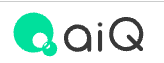

[disclaimer](./disclaimer.txt/)

# ALTERNATIVE DATA Evaluation Demo

## Evaluate aiQ POS Csmr Goods using aiQ Lab Alt Data Evaluation Tool

In [1]:
%load_ext autoreload
%autoreload 2

### Step1: Import Library

In [2]:
import numpy as np
import pandas as pd
import plotly.io

for_html = False
if for_html == True:
    plotly.offline.init_notebook_mode()
else:
    plotly.io.renderers.default = 'iframe'

from utils.shortcut import single_dataset as sc
from aiq_strategy_robot.data.data_accessor import DAL

In [3]:
sdh = DAL()

### Step2: Load Data
Retrieve each factor and register it to `handler`.
> In this sample, retrieval and registration operations are omitted.

In [4]:
sdh.extract.clear()

#  Load Alternative Data
data_id_alt = sc.register_alt_data(sdh)

#  Load Fundamental Data
data_id_funda = sc.register_fundamental_data(sdh)

# Load market data
data_id_mkt = sc.register_market_data(sdh)

display(sdh.get_raw_data(data_id_alt).tail())
display(sdh.get_raw_data(data_id_funda).tail())
display(sdh.get_raw_data(data_id_mkt).tail())

pos_sales     share  unit_price  unit_price_vs_ind
ticker  datetime                                                      
9997-JP 2024-02-04   0.012324  0.000572    0.691312           0.493701
        2024-02-11   0.005229  0.000243    0.829920           0.575624
        2024-02-18   0.008494  0.000395    0.813988           0.557915
        2024-02-25   0.006700  0.000317    0.768075           0.509813
        2024-03-03   0.008056  0.000368    0.798211           0.560644

sales
ticker  datetime           
9997-JP 2022-12-31  61675.0
        2023-03-31  51922.0
        2023-06-30  51842.0
        2023-09-30  44263.0
        2023-12-31  60173.0

close
ticker  datetime         
9997-JP 2024-03-15  620.0
        2024-03-18  625.0
        2024-03-19  629.0
        2024-03-21  629.0
        2024-03-22  631.0

In [5]:
# Set Alias (Optional)
sdh.set_alias({
    data_id_alt: 'aiq_pos_csmr_goods',
    data_id_funda: 'sales',
    data_id_mkt: 'market'
})

# Check if the data is registered OK.
sdh.extract_definition

,category,data_source,source,table,alias,tickers,index,start_datetime,end_datetime
data_id,,,,,,,,,
1,RawData,external,Unknown,Unknown,aiq_pos_csmr_goods,"[1301-JP, 1332-JP, 1333-JP, 1379-JP, 1380-JP, ...","[ticker, datetime]",2008-03-16 00:00:00,2024-03-03 00:00:00
2,RawData,external,Unknown,Unknown,sales,"[1301-JP, 1332-JP, 1333-JP, 1379-JP, 1380-JP, ...","[ticker, datetime]",2008-03-31 00:00:00,2024-01-31 00:00:00
3,RawData,external,Unknown,Unknown,market,"[1301-JP, 1332-JP, 1333-JP, 1379-JP, 1380-JP, ...","[ticker, datetime]",2008-03-14 00:00:00,2024-03-22 00:00:00


### Step3: Correlation Analysis

#### Step 3.1: measuring usefulness against fundamentals

In [6]:
from aiq_strategy_robot.evaluator import AltDataEvaluator

# Initialize AltDataEvaluator
ade = AltDataEvaluator(sdh)

In [7]:
features = sdh.get_raw_data(data_id_alt).columns
features

Index(['pos_sales', 'share', 'unit_price', 'unit_price_vs_ind'], dtype='object')

##### Visualisation of Alt Data and Fundamental data for any one ticker

In [8]:
sample_target = "2281-JP"

sdh.transform.clear()
funda_Q_ids = sdh.transform.resample(data_id=data_id_funda, rule='Q', func='last').variable_ids
alt_Q_ids = sdh.transform.resample(data_id=data_id_alt, rule='Q', func='mean').variable_ids

Variables being created: 100%|██████████| 1/1 [00:00<00:00, 49.47it/s]


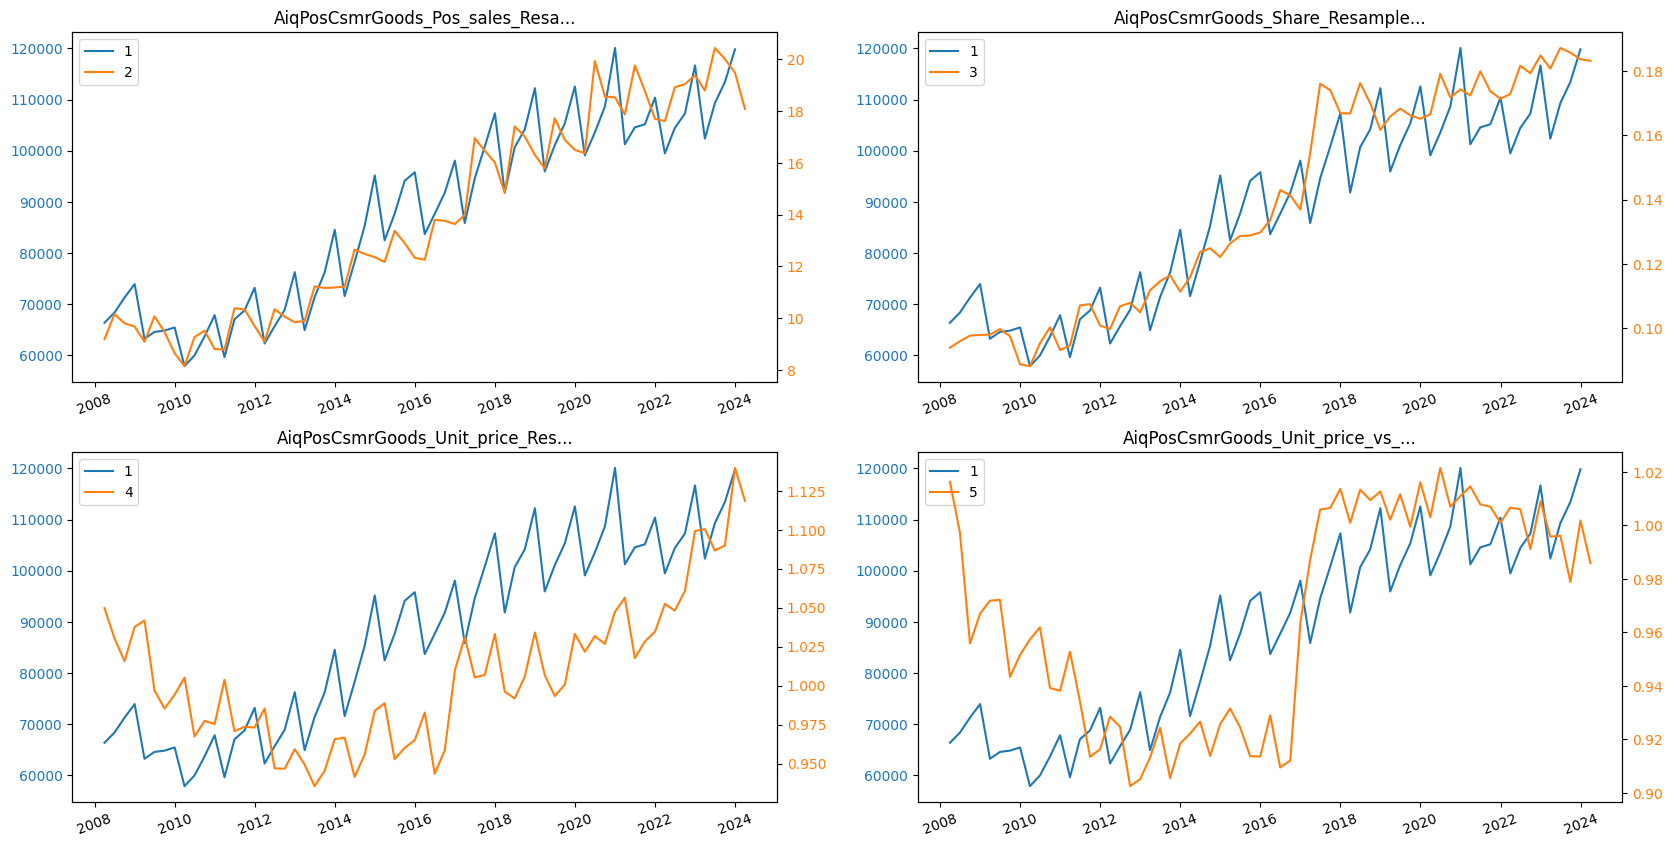

In [9]:
sdh.show_line_one_target(
    target=sample_target, #どの ticker のデータを描画するかを決めます
    y=funda_Q_ids[0], #y軸に表示するデータを variable_id で指定します
    X= alt_Q_ids, #x軸に表示するデータを variable_id の list で指定します（複数のグラフを一気に表示する時に list にします）
    col_num=2, #1行にいくつのグラフを表示するかを決めます
    vname_len_limit=30, #タイトルにXのvariable_id の変数名が表示されますが、表示を短くするために文字数を指定します
)

##### Visualisation of Alt data shifted in several patterns.

In [10]:
alt_Q_shift_1_ids = sdh.transform.shift(data_id=data_id_alt, periods=1).resample(rule='Q', func='mean').variable_ids
alt_Q_shift_2_ids = sdh.transform.shift(data_id=data_id_alt, periods=2).resample(rule='Q', func='mean').variable_ids
alt_Q_shift_3_ids = sdh.transform.shift(data_id=data_id_alt, periods=3).resample(rule='Q', func='mean').variable_ids
alt_Q_shift_4_ids = sdh.transform.shift(data_id=data_id_alt, periods=4).resample(rule='Q', func='mean').variable_ids

Variables being created: 100%|██████████| 8/8 [00:00<00:00, 14.23it/s]


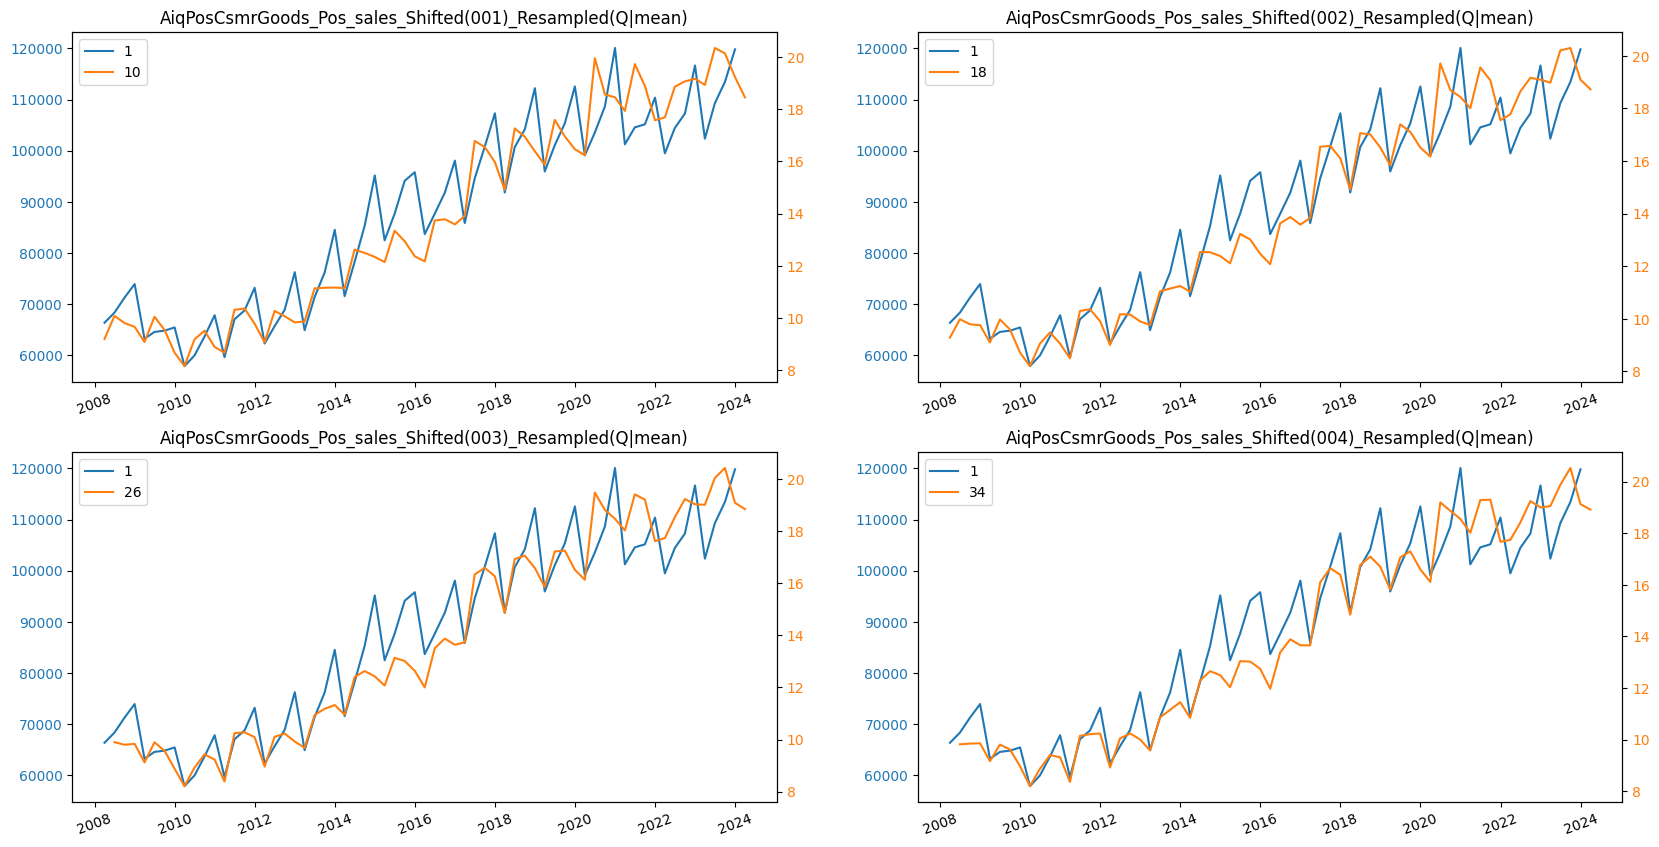

In [11]:
# View Sales vs Pos Sales
sdh.show_line_one_target(
    target=sample_target,
    y=funda_Q_ids[0],
    X=[alt_Q_shift_1_ids[0], alt_Q_shift_2_ids[0], 
       alt_Q_shift_3_ids[0], alt_Q_shift_4_ids[0]],
    col_num=2
)

##### Logarithmic transformation and correlation checks.

In [12]:
sales_id = sdh.transform.log_diff(fields=funda_Q_ids, periods=4).diff(periods=1).variable_ids[-1]
alt_Q_shift_0_logdiff_ids = sdh.transform.log_diff(fields=alt_Q_ids, periods=4).variable_ids
alt_Q_shift_1_logdiff_ids = sdh.transform.log_diff(fields=alt_Q_shift_1_ids, periods=4).diff(periods=1).variable_ids
alt_Q_shift_2_logdiff_ids = sdh.transform.log_diff(fields=alt_Q_shift_2_ids, periods=4).diff(periods=1).variable_ids
alt_Q_shift_3_logdiff_ids = sdh.transform.log_diff(fields=alt_Q_shift_3_ids, periods=4).diff(periods=1).variable_ids
alt_Q_shift_4_logdiff_ids = sdh.transform.log_diff(fields=alt_Q_shift_4_ids, periods=4).diff(periods=1).variable_ids

# Check application of method chain.
sdh.transform.show_method_chain()

,data_id,root,step_001,step_002,step_003
proc_id,,,,,
eaead429,2,"resample(rule=""Q"", func=""last"", origin=""start_day"")",log_diff(periods=4),diff(periods=1),-
bd1cfd55,1,"resample(rule=""Q"", func=""mean"", origin=""start_day"")",log_diff(periods=4),-,-
874ae391,1,shift(periods=1),"resample(rule=""Q"", func=""mean"", origin=""start_day"")",log_diff(periods=4),diff(periods=1)
a9ca397b,1,shift(periods=2),"resample(rule=""Q"", func=""mean"", origin=""start_day"")",log_diff(periods=4),diff(periods=1)
e862150f,1,shift(periods=3),"resample(rule=""Q"", func=""mean"", origin=""start_day"")",log_diff(periods=4),diff(periods=1)
9d4b351d,1,shift(periods=4),"resample(rule=""Q"", func=""mean"", origin=""start_day"")",log_diff(periods=4),diff(periods=1)


##### Calculation of correlations.

In [13]:
rho_pool = pd.DataFrame()
rho_pool['n_shift=0'] = ade.compu_rho(alt_Q_shift_0_logdiff_ids, sales_id, rename_features=features)
rho_pool['n_shift=1'] = ade.compu_rho(alt_Q_shift_1_logdiff_ids, sales_id, rename_features=features)
rho_pool['n_shift=2'] = ade.compu_rho(alt_Q_shift_2_logdiff_ids, sales_id, rename_features=features)
rho_pool['n_shift=3'] = ade.compu_rho(alt_Q_shift_3_logdiff_ids, sales_id, rename_features=features)
rho_pool['n_shift=4'] = ade.compu_rho(alt_Q_shift_4_logdiff_ids, sales_id, rename_features=features)
display(rho_pool.xs('t-val', level=1).sort_values(rho_pool.columns[0], ascending=False))

Variables being created: 100%|██████████| 14/14 [00:00<00:00, 16.83it/s]


,n_shift=0,n_shift=1,n_shift=2,n_shift=3,n_shift=4
pos_sales,5.172258,11.830420,8.804926,6.494567,5.047130
share,0.988347,5.745472,4.649866,3.393505,3.513294
unit_price_vs_ind,-1.047745,0.161389,-0.083414,-0.240519,-0.183557
unit_price,-2.473243,-0.919916,-1.247396,-1.654100,-1.577578


##### Select the top 5 most highly correlated features

In [14]:
rho_time = ade.compu_rho(alt_Q_shift_1_logdiff_ids, sales_id, by='ticker', rename_features=features)
rho_time.T.xs('t-val', level=1).sort_values('pos_sales', ascending=False).head()

,pos_sales,share,unit_price,unit_price_vs_ind
ticker,,,,
4452-JP,6.804325,2.962737,5.458577,2.882926
2220-JP,6.744614,4.253203,-0.227348,-0.725660
2919-JP,6.020033,-0.168539,1.869244,2.445909
2221-JP,6.003516,3.729421,-0.728411,0.431869
2804-JP,5.904020,0.288348,1.136534,-2.211117


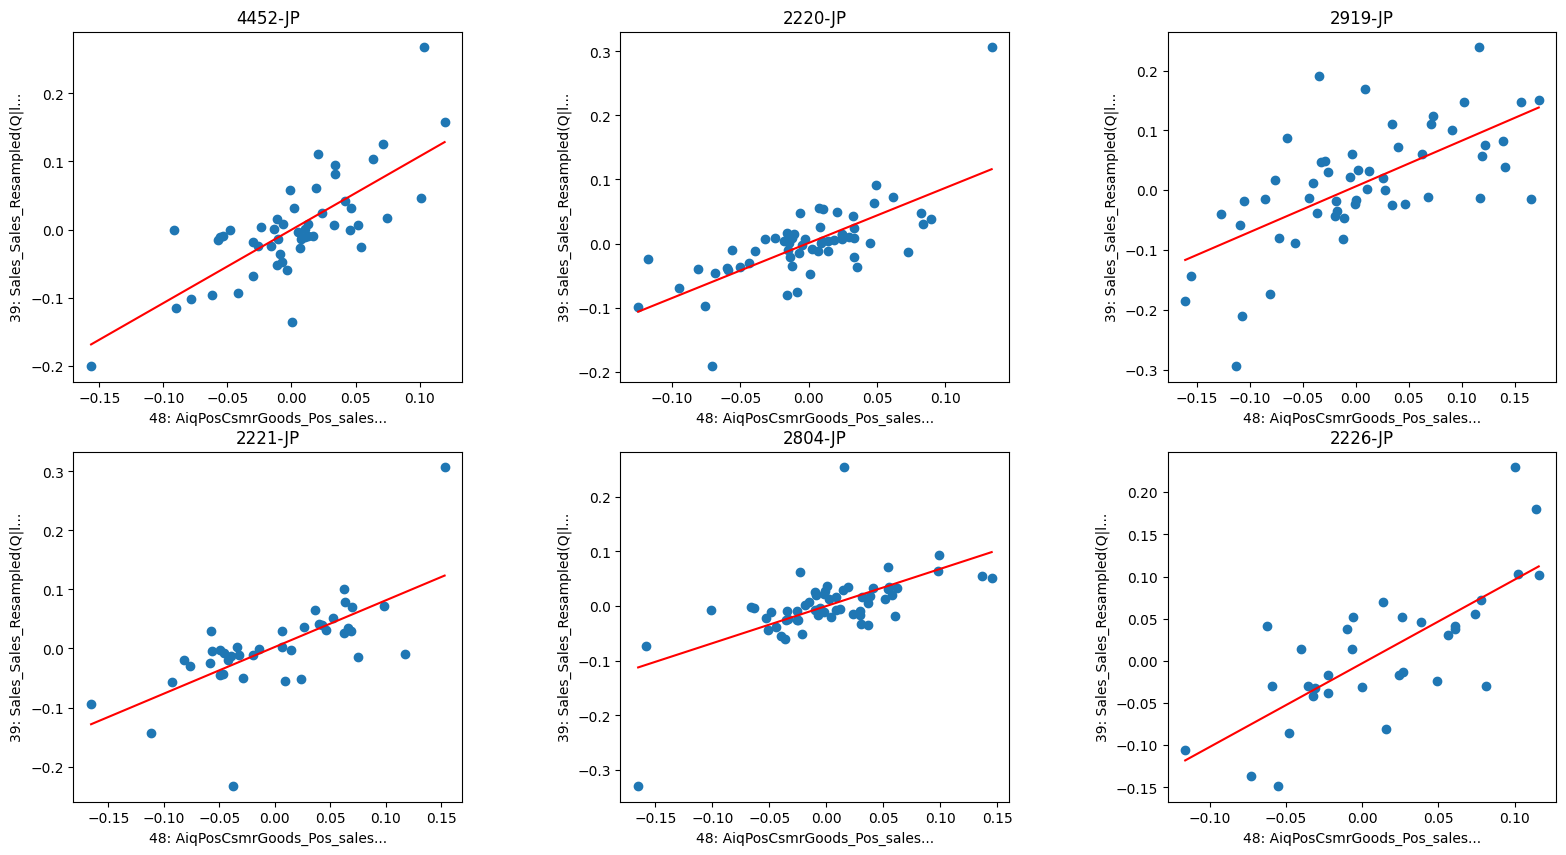

In [15]:
top6tickers = rho_time.T.xs('t-val', level=1).sort_values('pos_sales', ascending=False).index[:6]

sdh.show_scatter_per_target(
    y=sales_id,
    x=alt_Q_shift_1_logdiff_ids[0],
    targets=top6tickers,
    col_num=3,
    vname_len_limit=25,
)

#### Step 3.2: measuring usefulness against market data
Likewise, the same evaluation can be done for market price returns.
In this example, how quarterly aggregated alternative data correlates with market_price returns is measured.

In [16]:
mkt_W_close_id = sdh.transform.resample(data_id=data_id_mkt, rule='W', fields='close', func='last').variable_ids[-1]
alt_W_shift_0_ids = sdh.transform.resample(data_id=data_id_alt, rule='W', func='mean').variable_ids

Variables being created: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s]


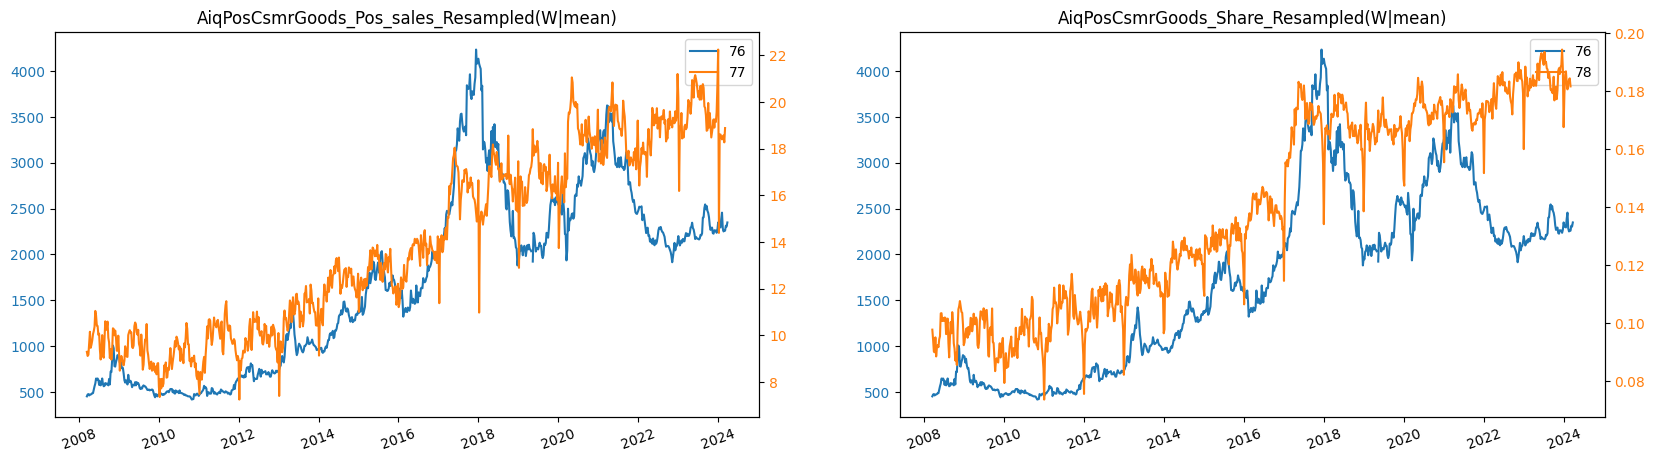

In [17]:
sdh.show_line_one_target(
    target=sample_target,
    y=mkt_W_close_id,
    X=alt_W_shift_0_ids[:2],
    col_num=2
)

In [18]:
alt_W_shift_1_ids = sdh.transform.shift(data_id=data_id_alt, periods=1).resample(rule='W', func='mean').sma(periods=12).variable_ids
alt_W_shift_2_ids = sdh.transform.shift(data_id=data_id_alt, periods=2).resample(rule='W', func='mean').sma(periods=12).variable_ids
alt_W_shift_3_ids = sdh.transform.shift(data_id=data_id_alt, periods=3).resample(rule='W', func='mean').sma(periods=12).variable_ids
alt_W_shift_4_ids = sdh.transform.shift(data_id=data_id_alt, periods=4).resample(rule='W', func='mean').sma(periods=12).variable_ids
alt_W_shift_5_ids = sdh.transform.shift(data_id=data_id_alt, periods=5).resample(rule='W', func='mean').sma(periods=12).variable_ids
alt_W_shift_6_ids = sdh.transform.shift(data_id=data_id_alt, periods=6).resample(rule='W', func='mean').sma(periods=12).variable_ids
alt_W_shift_7_ids = sdh.transform.shift(data_id=data_id_alt, periods=7).resample(rule='W', func='mean').sma(periods=12).variable_ids
alt_W_shift_8_ids = sdh.transform.shift(data_id=data_id_alt, periods=8).resample(rule='W', func='mean').sma(periods=12).variable_ids

Variables being created: 100%|██████████| 10/10 [00:01<00:00,  6.56it/s]


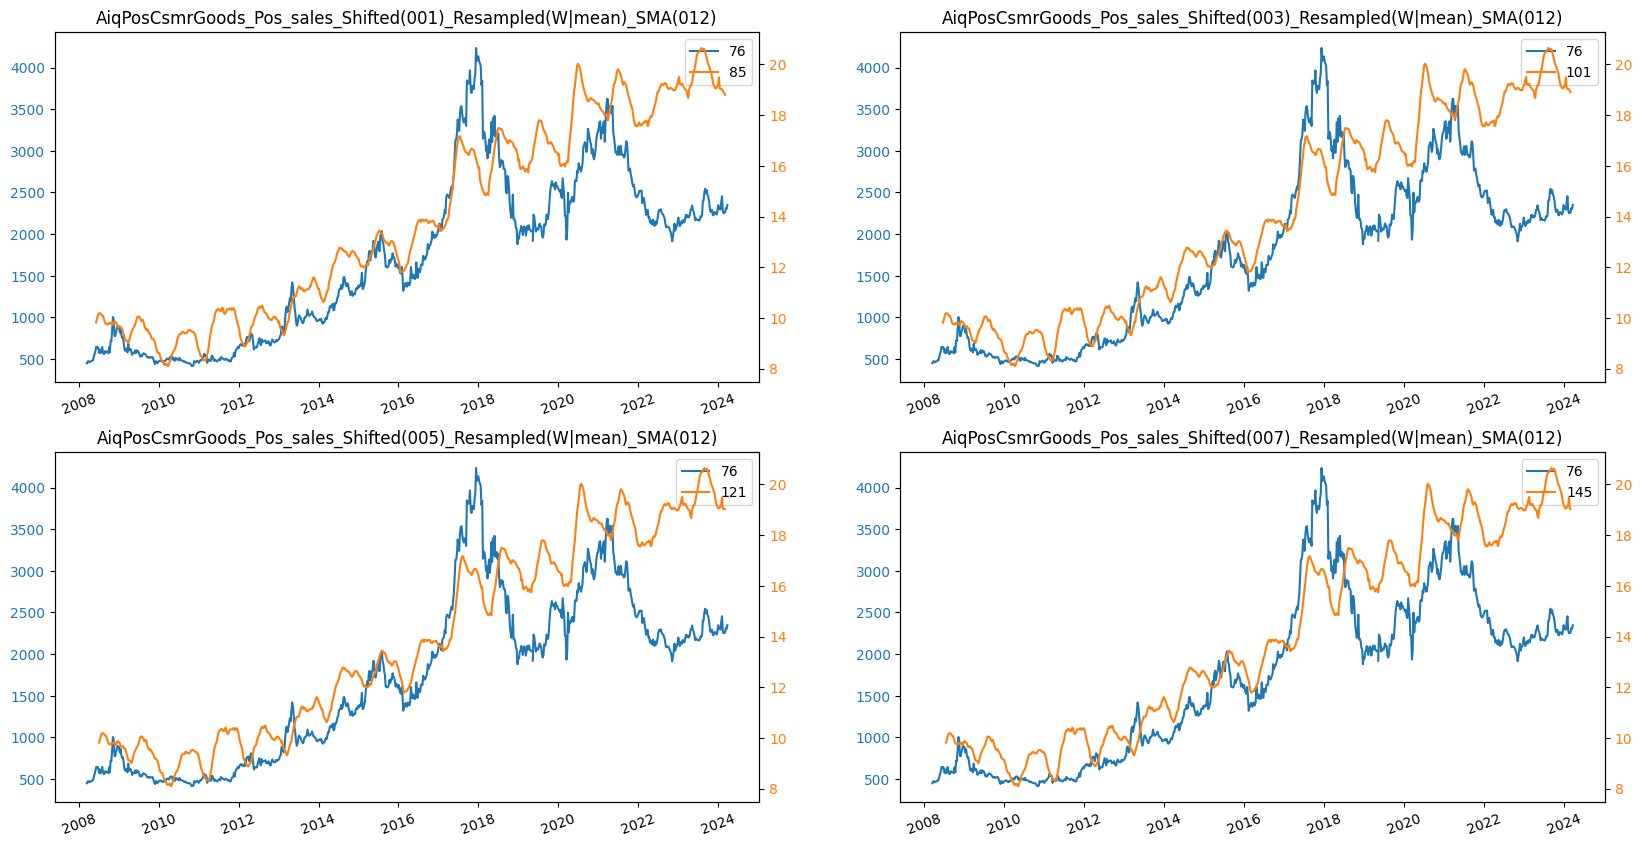

In [19]:
# View Sales vs Pos Sales
sdh.show_line_one_target(
    target=sample_target,
    y=mkt_W_close_id,
    X=[alt_W_shift_1_ids[0], alt_W_shift_3_ids[0], 
       alt_W_shift_5_ids[0], alt_W_shift_7_ids[0]],
    col_num=2
)

Transformation

In [20]:
alt_W_shift_0_sma12_logdiff_ids = sdh.transform.log_diff(fields=alt_W_shift_0_ids, periods=52).variable_ids
alt_W_shift_1_sma12_logdiff_ids = sdh.transform.log_diff(fields=alt_W_shift_1_ids, periods=52).variable_ids
alt_W_shift_2_sma12_logdiff_ids = sdh.transform.log_diff(fields=alt_W_shift_2_ids, periods=52).variable_ids
alt_W_shift_3_sma12_logdiff_ids = sdh.transform.log_diff(fields=alt_W_shift_3_ids, periods=52).variable_ids
alt_W_shift_4_sma12_logdiff_ids = sdh.transform.log_diff(fields=alt_W_shift_4_ids, periods=52).variable_ids
alt_W_shift_5_sma12_logdiff_ids = sdh.transform.log_diff(fields=alt_W_shift_5_ids, periods=52).variable_ids
alt_W_shift_6_sma12_logdiff_ids = sdh.transform.log_diff(fields=alt_W_shift_6_ids, periods=52).variable_ids
alt_W_shift_7_sma12_logdiff_ids = sdh.transform.log_diff(fields=alt_W_shift_7_ids, periods=52).variable_ids
alt_W_shift_8_sma12_logdiff_ids = sdh.transform.log_diff(fields=alt_W_shift_8_ids, periods=52).variable_ids

close_ret = sdh.transform.dropna(fields=mkt_W_close_id, how='all').log_diff(periods=1, names='ret').variable_ids[-1]

funda_Q_ids# メソッドチェーンを確認
sdh.transform.show_method_chain()

,data_id,root,step_001,step_002,step_003
proc_id,,,,,
eaead429,2,"resample(rule=""Q"", func=""last"", origin=""start_day"")",log_diff(periods=4),diff(periods=1),-
bd1cfd55,1,"resample(rule=""Q"", func=""mean"", origin=""start_day"")",log_diff(periods=4),-,-
874ae391,1,shift(periods=1),"resample(rule=""Q"", func=""mean"", origin=""start_day"")",log_diff(periods=4),diff(periods=1)
a9ca397b,1,shift(periods=2),"resample(rule=""Q"", func=""mean"", origin=""start_day"")",log_diff(periods=4),diff(periods=1)
e862150f,1,shift(periods=3),"resample(rule=""Q"", func=""mean"", origin=""start_day"")",log_diff(periods=4),diff(periods=1)
9d4b351d,1,shift(periods=4),"resample(rule=""Q"", func=""mean"", origin=""start_day"")",log_diff(periods=4),diff(periods=1)
ba62284d,1,"resample(rule=""W"", func=""mean"", origin=""start_day"")",log_diff(periods=52),-,-
966d79f0,1,shift(periods=1),"resample(rule=""W"", func=""mean"", origin=""start_day"")",sma(periods=12),log_diff(periods=52)
7a370acd,1,shift(periods=2),"resample(rule=""W"", func=""mean"", origin=""start_day"")",sma(periods=12),log_diff(periods=52)


Calculation

In [21]:
rho_pool = pd.DataFrame()
rho_pool['n_shift=0, sma=12, diff1'] = ade.compu_rho(alt_W_shift_0_sma12_logdiff_ids, close_ret, rename_features=features)
rho_pool['n_shift=1, sma=12, diff1'] = ade.compu_rho(alt_W_shift_1_sma12_logdiff_ids, close_ret, rename_features=features)
rho_pool['n_shift=2, sma=12, diff1'] = ade.compu_rho(alt_W_shift_2_sma12_logdiff_ids, close_ret, rename_features=features)
rho_pool['n_shift=3, sma=12, diff1'] = ade.compu_rho(alt_W_shift_3_sma12_logdiff_ids, close_ret, rename_features=features)
rho_pool['n_shift=4, sma=12, diff1'] = ade.compu_rho(alt_W_shift_4_sma12_logdiff_ids, close_ret, rename_features=features)
rho_pool['n_shift=5, sma=12, diff1'] = ade.compu_rho(alt_W_shift_5_sma12_logdiff_ids, close_ret, rename_features=features)
rho_pool['n_shift=6, sma=12, diff1'] = ade.compu_rho(alt_W_shift_6_sma12_logdiff_ids, close_ret, rename_features=features)
rho_pool['n_shift=7, sma=12, diff1'] = ade.compu_rho(alt_W_shift_7_sma12_logdiff_ids, close_ret, rename_features=features)
rho_pool['n_shift=8, sma=12, diff1'] = ade.compu_rho(alt_W_shift_8_sma12_logdiff_ids, close_ret, rename_features=features)

display(rho_pool.xs('t-val', level=1).sort_values(rho_pool.columns[0], ascending=False))

Variables being created: 100%|██████████| 16/16 [00:02<00:00,  6.57it/s]


,"n_shift=0, sma=12, diff1","n_shift=1, sma=12, diff1","n_shift=2, sma=12, diff1","n_shift=3, sma=12, diff1","n_shift=4, sma=12, diff1","n_shift=5, sma=12, diff1","n_shift=6, sma=12, diff1","n_shift=7, sma=12, diff1","n_shift=8, sma=12, diff1"
pos_sales,3.988608,6.558211,6.288663,6.414349,6.387721,6.118143,5.487600,5.382758,4.938323
share,2.337484,3.512375,3.308825,3.092316,3.389276,3.285500,3.120749,3.122486,3.040014
unit_price,-0.746125,0.857340,1.055606,1.200542,1.098926,1.213180,1.053002,0.869211,0.516296
unit_price_vs_ind,-0.984050,-1.393382,-1.286122,-1.087548,-1.090011,-1.084866,-1.408818,-1.514960,-1.700693


##### Select the top 5 most highly correlated features

In [22]:
rho_time = ade.compu_rho(alt_W_shift_1_sma12_logdiff_ids, close_ret, by='ticker', rename_features=features)
rho_time.T.xs('t-val', level=1).sort_values('pos_sales', ascending=False).head()

,pos_sales,share,unit_price,unit_price_vs_ind
ticker,,,,
2281-JP,3.505645,3.369123,2.137623,1.162140
5194-JP,3.188901,3.761244,2.029955,1.704698
2212-JP,3.056784,1.782047,1.017993,-0.322797
2884-JP,2.914284,1.194342,0.175939,1.497298
2266-JP,2.466982,0.240809,-1.466657,-0.826028


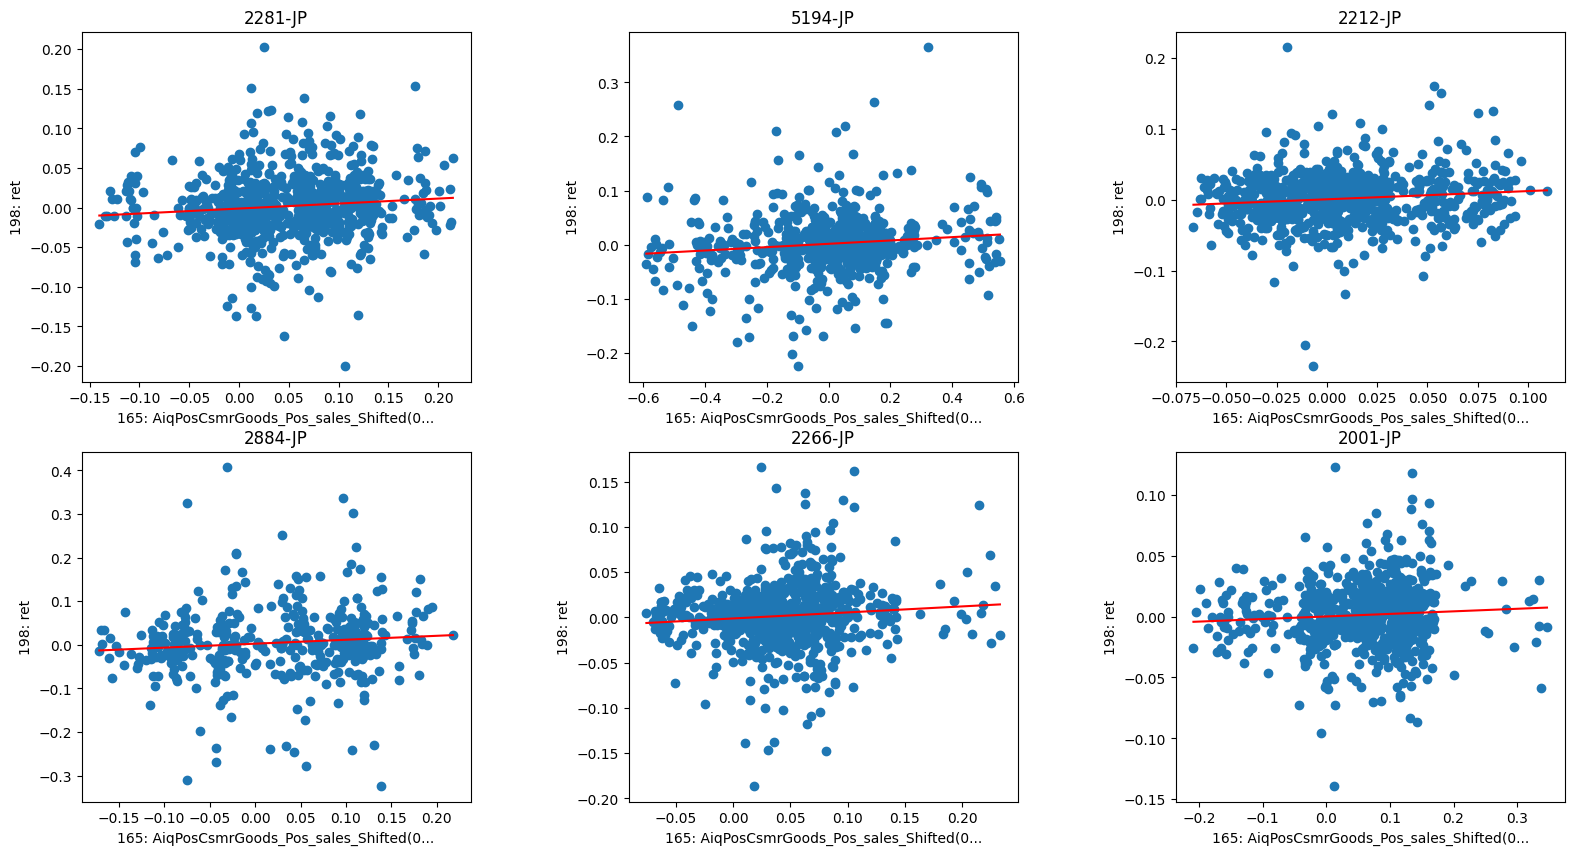

In [23]:
top6tickers = rho_time.T.xs('t-val', level=1).sort_values('pos_sales', ascending=False).index[:6]

sdh.show_scatter_per_target(
    y=close_ret,
    x=alt_W_shift_1_sma12_logdiff_ids[0],
    targets=top6tickers,
    col_num=3,
    vname_len_limit=35,
)

### Step4: Quantile Backtest
Back-testing using the most highly correlated features against market data.

In [24]:
# define the parameters for factor choice.
nq = 3
exe_cost = 0.0005

# Use pre-created variable ID
pos_sales = alt_W_shift_1_sma12_logdiff_ids[0]
ret = close_ret

In [25]:
dfqret, stats, dfsigqt = ade.q_backtest(
    pos_sales,
    ret,
    nq=nq,
    exe_cost=exe_cost,
    plot=True,
    stats=True
)

,cum.Ret,ann.Ret,ann.Std,R/R,Win_R,ann.TurnOver,Max_DD,Calmar Ratio
#1,0.520426,0.035288,0.143565,0.245798,0.561769,2.753615,-0.496438,0.071082
#2,0.742365,0.050337,0.136019,0.370071,0.573472,5.173438,-0.390692,0.128840
#3,1.310755,0.088877,0.140243,0.633737,0.596879,2.702957,-0.426742,0.208269
#3-#1,0.790330,0.053589,0.049532,1.081913,0.592978,5.456571,-0.076768,0.698069
#3-#1(cost),0.750145,0.050864,0.049534,1.026859,0.587776,5.456571,-0.078143,0.650914
